In [1]:
import sparse


import subprocess
import shlex
import pandas as pd
import numpy as np

import glob
import os
import wget
import requests
import glob
import time
import dask
import h5py

from Bio import SeqIO
import pickle
import sys
sys.setrecursionlimit( 10 **9 )
from sklearn.cluster import *
from sklearn.metrics import roc_curve , precision_recall_curve , auc

import scipy
import copy
from numpy import linalg as LA
from matplotlib import pyplot as plt
import random
import h5py
import itertools
import dendropy
import os
import psutil
import seaborn as sns


overwrite = False
jk_iterations = 5
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'

In [2]:
import torch
#create graphs on the fly to represent pairs of profiles
device = torch.device('cuda' )
#device = torch.device('cpu')
print(device)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import ChebConv
from torch_geometric.nn import  to_hetero
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData ,InMemoryDataset
import copy
import time
import pickle
import random

In [4]:
filedir = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/'

In [5]:
files = glob.glob( filedir + 'datasets/covid_data/msa_0730/msa_0730.fasta*02021-09-27T12:05:34*pkl')
print(files)

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_02021-09-27T12:05:34.021732small_test0.001_BS_coevmats.pkl', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_02021-09-27T12:05:34.021732small_test0.1_BS_coevmats.pkl', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_02021-09-27T12:05:34.021732small_test0.01_BS_coevmats.pkl']


In [6]:
#treefile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
#alnfile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
alnfile = filedir + 'datasets/covid_data/msa_0730/msa_0730.fasta'
treefile = filedir + 'datasets/covid_data/msa_0730/global.tree'
modeldir = filedir+'datasets/covid_data/structs/'

alnh5 = alnfile+'.h5'
#ts = '2021-08-08T11:16:34.358764'
ts = '2021-08-08T14:37:59.736512'
events = alnfile+'*'+ts+'*'
eventmats = glob.glob(events)

In [7]:
with open(treefile) as treelines:
    print( next(treelines)[0:1000])

(EPI_ISL_402119:0,(EPI_ISL_412026:0,EPI_ISL_403963:0,EPI_ISL_416629:0,EPI_ISL_402125:0,EPI_ISL_447107:0,EPI_ISL_476797:0,(((((EPI_ISL_425872:3.3155e-05,EPI_ISL_2589959:6.6256e-05)0.900:5e-09,((EPI_ISL_464788:3.3157e-05,(EPI_ISL_441767:6.6819e-05,EPI_ISL_441280:3.3402e-05,EPI_ISL_459530:6.6819e-05,EPI_ISL_459522:6.6819e-05,EPI_ISL_489396:6.6819e-05)1.000:5e-09)0.990:5e-09,((EPI_ISL_529149:0.000165688,EPI_ISL_416611:5e-09,EPI_ISL_416600:5e-09,EPI_ISL_416627:5e-09,EPI_ISL_416590:5e-09)0.940:5e-09,(EPI_ISL_2589902:5e-09,(EPI_ISL_2500492:0.000468113,((EPI_ISL_437044:3.3402e-05,EPI_ISL_437059:3.3542e-05)1.000:5e-09,EPI_ISL_853559:5e-09)0.880:3.3134e-05)0.920:5e-09)0.000:5e-09)0.000:5e-09)0.000:5e-09)1.000:5e-09,(((EPI_ISL_499813:3.3484e-05,(EPI_ISL_482686:0.000132791,EPI_ISL_464201:3.3129e-05)0.000:5e-09)0.000:5e-09,EPI_ISL_468833:3.3406e-05)1.000:6e-09,(EPI_ISL_2341358:3.3485e-05,EPI_ISL_469644:9.9559e-05,EPI_ISL_492388:9.9559e-05)0.810:5e-09)0.180:5e-09)0.000:5e-09,(EPI_ISL_451359:3.3146e-

In [8]:
tree = dendropy.Tree.get( path=treefile, schema='newick' )

In [9]:
#setup the internal nodes for the fitch algo
for i,l in enumerate(tree.nodes()):
    l.event = {}
    l.scores = {}
    l.symbols = None
    l.char= None
    l.matrow = i
    

In [10]:
import networkx as nx
import colour
#quick and dirty check of trees

def tree_circle(node, start , sliver  ):
    if start == True :
        global count
        count = 0
    for i,child in enumerate(node.child_nodes()):
        if child.is_leaf() == True:
            child.radians = count*sliver
            count+=1
        if child.radians is None and child.is_leaf() == False :
            tree_circle( child , start = False , sliver = sliver  )
    radians = np.mean([ child.radians if child.radians else 0 for child in node.child_nodes() ])
    if node.radians is None:
        node.radians = radians

def phylograph(treein,labels , title = None):
    N = len(treein.nodes())
    tree = copy.deepcopy(treein)
    pdm = tree.phylogenetic_distance_matrix()
    sliver = 2*np.pi / len(tree.leaf_nodes())
    
    root = tree.seed_node
    radii = [ n.distance_from_root() for n in tree.nodes()]
    for n in tree.nodes():
        n.radians = None
    tree_circle(tree.seed_node, start=True , sliver = sliver)
    thetas = [n.radians for n in tree.nodes() ]
    pos = { i: [ np.sin(thetas[i])*radii[i] , np.cos(thetas[i])*radii[i]] for i in range(len(thetas)) }
    index = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    connectmat = np.zeros(( N ,  N ) )
    connectmat[index[:,0],index[:,1]] = 1 
    connectmat += connectmat.T
    G = nx.from_numpy_array(connectmat)
    red = colour.Color("red")
    blue = colour.Color("blue")
    crange = dict( zip ( list(set(labels)),  [ c.hex_l for c in list(red.range_to(blue, len(set(labels)) ) ) ] ) )
    colors = [crange[n] for n in labels ]
    #color according to downstream node
    edge_colors= [crange[labels[v]] for u,v in G.edges() ]
    #node size inversly proportional to number in graph
    plt.figure(figsize= (20,20) )
    if title:
        plt.title(title)
    nx.draw_networkx(G, pos = pos,  node_color = colors , node_size = 5, width = .5 , edge_color = edge_colors , with_labels=False)
    plt.show()

In [11]:
def ROC_curve(y_data, label = None):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    for l in y_data:
        print(l)
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        fpr, tpr, _ = roc_curve(   y_pred_grd ,y_test)
        plt.plot(fpr, tpr, label=l + 'auc'+ str(auc(fpr, tpr) ))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_ROC.svg' )
    plt.show()
    
    
    plt.figure(figsize=(10,10))
    for l in y_data:
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        precision, recall, thresholds = precision_recall_curve( y_pred_grd, y_test)
        plt.plot( recall, precision , label= l )
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    
    plt.title('PR curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_PR.svg' )
    plt.show()
    
def ROC_curve_single(y_test, y_pred_grd):
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_test, y_pred_grd)
    plt.plot(fpr, tpr, label='single')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(  y_test , y_pred_grd)
    plt.plot(precision, recall , label='single')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

    plt.title('PR curve')
    plt.legend(loc='best')
    plt.show()


In [12]:
print( eventmats )

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_02021-08-08T14:37:59.736512small_test_BS_coevmats.pkl', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_22021-08-08T14:37:59.736512small_test_BS_coevmats.pkl', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fasta_12021-08-08T14:37:59.736512small_test_BS_coevmats.pkl']


In [13]:

if os.path.exists( alnfile + '_IDs.pkl'):
    with open( alnfile + '_IDs.pkl' , 'rb') as idxin:
        IDindex = pickle.loads(idxin.read())
    IDs = dict(zip( IDindex.values() , IDindex.keys() ) )
else:
    
    msa = SeqIO.parse(alnfile , format = 'fasta')
    def clipID(ID):
        return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
    IDs = {i:rec.id for i,rec in enumerate(msa)}
    IDindex = dict(zip( IDs.values() , IDs.keys() ) )
    print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )
    with open( alnfile + '_IDs.pkl' , 'wb') as idxout:
        idxout.write(pickle.dumps(IDindex))

In [14]:
print(len(IDindex))

2212775


In [15]:
models = '7DZW, 6vxx,6zxn,5x58,6cs0,6sc1,6nb6, 2jw8, 2xab, 4aud1, 1yo4, 2acf, 2wct, 3vc8, 2gt7, 3ee7, 2g9t, 3ee7, 2g9t, 6jyt, 1ysy, 6nur, 2g9t, 5c8u, 2g9t, 2xyq, 4mm3, 6cs2, 6acg, 6acj, 6ack, 2dd8, 2ghw, 6nb6, 6nb7'
#models = '6vxx,6zxn'
models = models.split(',')

from Bio.PDB import *
dl_url = 'http://files.rcsb.org/download/'
dl_url_err = 'http://files.rcsb.org/download/'

structs = {}
already = glob.glob( modeldir+'/*.pdb' )
print(already)
#pull complexes
for m in models:
    structfile = modeldir+m.upper().strip()+'.pdb'
    if structfile not in already:
        print(m)
        time.sleep(1)
        try:
            wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
            structs[m] = structfile
        except:
            try:
                wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
                structs[m] = structfile
            except:
                print('err', m )
    else:
        structs[m.strip()] = structfile


['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2XAB.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NUR.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/5C8U.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YSY.pdb', '/work/FAC/FBM/DBC/cdess

In [16]:
modelfiles = modeldir + '*.pdb'
modelfiles = glob.glob( modelfiles )
print(modelfiles)

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2XAB.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NUR.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/5C8U.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YSY.pdb', '/work/FAC/FBM/DBC/cdess

In [17]:
from Bio.PDB import MMCIFParser, PDBParser , PDBIO
from Bio.PDB.mmcifio import MMCIFIO
parser = PDBParser()
import warnings
from Bio import SeqUtils

###compile all pdbs to fasta 
converter = SeqUtils.IUPACData.protein_letters_3to1
converter = { res.upper():converter[res] for res in converter}
chain_sequences={}
for model in modelfiles:
    print(model)
    with warnings.catch_warnings():
        try:
            m = model.split('/')[-1].replace('pdb' , '') 
            warnings.simplefilter("ignore")
            structure = parser.get_structure(m, model)
            io=PDBIO()
            io.set_structure(structure)
            chain_sequences[model]= { c.id : ''.join(  [ converter[ r.get_resname()] for r in c.get_residues() if 'CA' in r ] ) for c in structure.get_chains() }
            chain_sequences[model]={ c: chain_sequences[model][c] for c in chain_sequences[model] if len(chain_sequences[model][c])> 0 }
        except:
            print('err', model)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb
err /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb
err /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2XAB.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NUR.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmo

In [18]:
with open( modeldir + 'struct_chains.fasta', 'w') as fastout:
    for model in chain_sequences:
        for c in chain_sequences[model]:
            fastout.write( '> '+model+ ':'+c + '\n' + chain_sequences[model][c] + '\n' )

In [19]:

from dask.distributed import fire_and_forget
from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
from dask_jobqueue import SLURMCluster
from dask.distributed import  utils_perf
import dask
import dask.bag as db
import dask.array as da
import dask.dataframe as dd
from dask.delayed import delayed
from dask import delayed, compute

distributed_computation = False

print('flashing up a dask cluster')
if distributed_computation == True:
    
    NCORE = 10
    njobs = 20
    print('deploying cluster')
    cluster = SLURMCluster(
        walltime='24:00:00',
        n_workers = NCORE,
        cores=NCORE,
        processes = NCORE,
        interface='ib0',
        memory="150GB",
        env_extra=[
        'source /scratch/dmoi/miniconda/etc/profile.d/conda.sh',
        'conda activate ML'
        ],
        scheduler_options={'interface': 'ens2f0' }
    )
    print(cluster.job_script())
    #cluster.adapt(minimum=10, maximum=30)
    cluster.scale(jobs=20)
    time.sleep(5)

    print(cluster)
    print(cluster.dashboard_link)
    client = Client(cluster , timeout='450s' , set_as_default=True )
else:
    if __name__ == '__main__':
        NCORE = 5
        njobs = 1
        print('testing')
        cluster = LocalCluster(n_workers = NCORE )    
        print(cluster.dashboard_link)
        client = Client(cluster)
print('done')

/users/dmoi/.local/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


flashing up a dask cluster
testing


2022-06-10 11:40:23,040 - distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/covid/validation_data/dask-worker-space/worker-6rpk4rrm', purging
2022-06-10 11:40:23,082 - distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/covid/validation_data/dask-worker-space/worker-00ofohhe', purging
2022-06-10 11:40:23,100 - distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/covid/validation_data/dask-worker-space/worker-ili7hgxc', purging
2022-06-10 11:40:23,104 - distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/covid/validation_data/dask-worker-space/worker-yiyw2sjp', purging
2022-06-10 11:40:23,107 - distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/covid/validation_data

http://127.0.0.1:8787/status
done


In [20]:
nucleotide_mutation = None
AA_mutation = None
for mat in eventmats:
    with open( mat , 'rb') as pklin:
        mats = pickle.loads(pklin.read())
        print(mats)
        if AA_mutation is None:
            nucleotide_mutation = mats[1]
            AA_mutation = mats[0]
        else:
            nucleotide_mutation += mats[1]
            AA_mutation += mats[0]
print(nucleotide_mutation)
print(AA_mutation)

(<COO: shape=(997916, 29809, 380), dtype=float64, nnz=738510, fill_value=0.0>, <COO: shape=(997916, 29809, 12), dtype=float64, nnz=1146069, fill_value=0.0>)
(<COO: shape=(997916, 29809, 380), dtype=float64, nnz=738222, fill_value=0.0>, <COO: shape=(997916, 29809, 12), dtype=float64, nnz=1146258, fill_value=0.0>)
(<COO: shape=(997916, 29809, 380), dtype=float64, nnz=738796, fill_value=0.0>, <COO: shape=(997916, 29809, 12), dtype=float64, nnz=1146546, fill_value=0.0>)
<COO: shape=(997916, 29809, 12), dtype=float64, nnz=2075009, fill_value=0.0>
<COO: shape=(997916, 29809, 380), dtype=float64, nnz=1338566, fill_value=0.0>


In [21]:
mat_cleanup = True
from scipy.stats import gamma

if mat_cleanup == True:
    for transition in range(AA_mutation.shape[2]):
        if transition % 10 == 0 :
            print(transition)
        coevmat = AA_mutation[:,:,transition]
        sumv = coevmat.sum(axis = 0).todense()

        posi = np.log(sumv[sumv>0])
        if len(posi)>0 and np.sum(posi)>10:
            
            try:
                a,loc, scale =gamma.fit(posi)
                probas = gamma.cdf( posi , a , loc , scale)

                if np.amax(probas)>.999:
                    thresh = np.amin(np.exp(posi[probas>.999]))
                #remove odd looking transition columns
            except:
                thresh  = 0
                
                if transition == 0:
                    AAmat = AA_mutation[:,:,transition].to_scipy_sparse()
                    #AAmat[:,sumv>thresh] = 0
                else:
                    AAmat_ =  scipy.sparse.csc_matrix(AA_mutation[:,:,transition].to_scipy_sparse())
                    #AAmat_[:,sumv>thresh] = 0
                    AAmat += scipy.sparse.coo_matrix(AAmat_)        
            cdf = np.array( np.cumsum(sumv) / np.sum(sumv))        
        else:
            if transition == 0:
                AAmat =  AA_mutation[:,:,transition].to_scipy_sparse()
            else:
                AAmat +=  AA_mutation[:,:,transition].to_scipy_sparse()
                
    with open( alnfile + 'AAmat_sum.pkl' , 'wb')as AAmatout:
        print(AAmat.shape)
        AAmatout.write(pickle.dumps(AAmat))
else:
    with open( alnfile + 'AAmat_sum.pkl' , 'rb')as AAmatout:
        AAmat = pickle.loads(AAmatout.read())


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170


/users/dmoi/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
(997916, 29809)


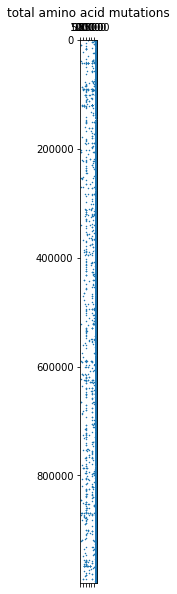

In [22]:
plt.figure(figsize=(20,10))
plt.spy(AAmat, markersize= .5)
plt.title('total amino acid mutations')
plt.show()




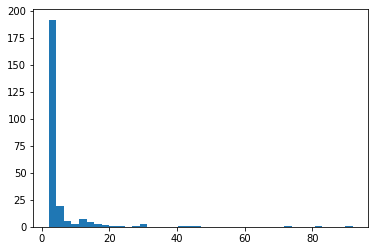

In [23]:
colsum = AAmat.sum(axis = 0)
colsum = colsum[colsum>1]
colsum = colsum[colsum<100]

plt.hist(colsum.flat , bins = 40)
plt.show()

In [24]:
#get a hist of nt and aa mutations per colunn

#filter out trivial ones w no change from analysis



In [25]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


2849.58984375


In [26]:
allowed_symbols = [ b'A', b'C', b'G' , b'T' ]
allowed_transitions = [ c1+c2 for c1 in allowed_symbols for c2 in allowed_symbols  if c1!= c2]
print('allowed transitions',allowed_transitions)

transition_dict = {  c : i  for i,c in enumerate( allowed_transitions )  }
rev_transition_dict= dict( zip(transition_dict.values(), transition_dict.keys()))
allowed_symbols = set(allowed_symbols)

print('transition dict', transition_dict)
ProteinAlphabet = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
allowed_AA_transitions = [ c1+c2 for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2]
transitiondict_AA = {  c : i  for i,c in enumerate( allowed_AA_transitions )  }
rev_transitiondict_AA = dict( zip(transitiondict_AA.values(), transitiondict_AA.keys()))


allowed transitions [b'AC', b'AG', b'AT', b'CA', b'CG', b'CT', b'GA', b'GC', b'GT', b'TA', b'TC', b'TG']
transition dict {b'AC': 0, b'AG': 1, b'AT': 2, b'CA': 3, b'CG': 4, b'CT': 5, b'GA': 6, b'GC': 7, b'GT': 8, b'TA': 9, b'TC': 10, b'TG': 11}


997916
nodes


/users/dmoi/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


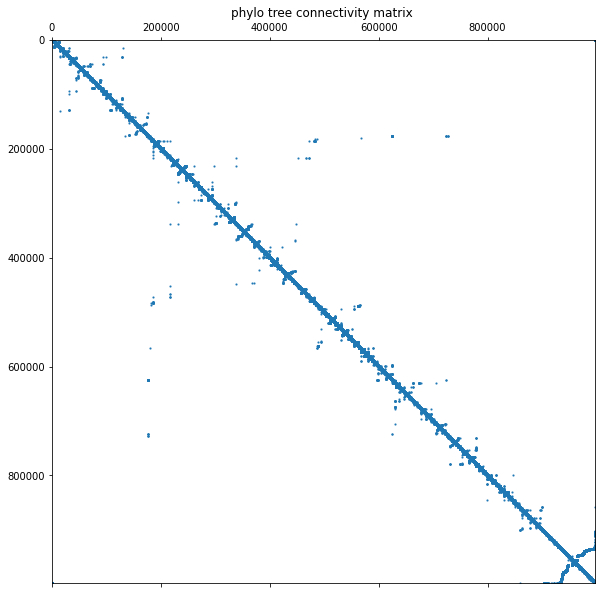

In [27]:
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None

matsize = len(tree.nodes())
print(matsize)
print('nodes')
#blur w connectivity mat
blurfactor =  .25
connectmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
lengths = np.array([ c.edge_length for n in tree.nodes() for c in n.child_nodes()])
total_len = np.sum(lengths)
#fill diagonal
#index = np.vstack( [index , np.array([ [n.matrow, n.matrow ] for n in tree.nodes() ]) ] )

connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1


#connectmat = connectmat.todense()
diag = [ i for i in range(connectmat.shape[0])]
connectmat[diag,diag] = 1
#connectmat = connectmat.todense()
#connectmat = scipy.sparse.csc_matrix(connectmat)
#np.fill_diagonal(connectmat , 1)
connectmat = scipy.sparse.coo_matrix(connectmat)
plt.figure( figsize=(10,10))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()

In [28]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


3053.640625


In [27]:
#####define the aln row and structure here, for dengue they should all be the same
selected_strain = list(IDindex.keys())[100]
import dask.array as da
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array']
    print(IDindex[selected_strain])
    print(selected_strain)
    #filter to columns without gaps
    non_gap = np.where( align_array[: , IDindex[selected_strain]] != b'-')[0]
    print(non_gap)
    print(non_gap.shape)
    sequence = align_array[ non_gap , IDindex[selected_strain]]
    print(np.unique(sequence))

100
EPI ISL 2874801
[  162   163   164 ... 40398 40399 40400]
(29809,)
[b'A' b'C' b'G' b'K' b'N' b'T']


In [28]:
#find the amino acid chains in the structs
import subprocess
import shlex

with open( alnfile + 'refgeno.fasta' , 'w' ) as fastout:
    fastout.write('>'+selected_strain + '\n')
    fastout.write( ''.join( c.decode() for c in list(sequence) ) + '\n' )
qfile =  alnfile + 'refgeno.fasta'

In [29]:
blastpath = filedir + 'software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/'


print(modeldir + 'covid_structs.fasta')
def runblastx( qseq , blastpath = blastpath , outannot = alnfile+'struct_blastout.txt' , db = modeldir + 'struct_chains.fasta' , outfmt = None ):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = blastpath+'blastx -query '+ qfile + ' -db '+db+' -outfmt' + outfmt + ' -out ' + outannot  
    print(args)
    p = subprocess.run( shlex.split(args) )
    return p , outannot

p,annot = runblastx(qfile)
print(annot)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/covid_structs.fasta
 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
/work/FAC/FBM/DBC/cdessim2/default/dmoi/software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/blastx -query /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastarefgeno.fasta -db /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta -outfmt "10 qseqid sseqid qlen slen qstart qend qframe evalue  "  -out /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt


In [30]:
annotation = pd.read_csv(  annot , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]

annotation['struct'] = annotation.sseqid.map( lambda x : x.split(':')[0].split('/')[-1].replace('.pdb','') )
annotation['chain'] = annotation.sseqid.map( lambda x : x.split(':')[1] )
annotation.to_csv( alnfile +'struct_annotation.csv'  )
print(annotation)
#make annotation for dengue orfs
#find equivalent structures in multimers

   qseqid                                             sseqid   qlen  slen  \
0     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
3     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1060   
4     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1054   
..    ...                                                ...    ...   ...   
88    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    87   
89    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
90    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
91    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    81   
92    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    70   

    qstart   qend  qframe        evalue struct chain  
0    21604  24966   

In [31]:
chainlen = dict( zip ( annotation.struct + annotation.chain , annotation.slen ))

In [32]:
filter_annot = True
if filter_annot == True:
    annotation = annotation[annotation.struct == '7DZW']

In [33]:
print(annotation)

  qseqid                                             sseqid   qlen  slen  \
0    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   

   qstart   qend  qframe  evalue struct chain  
0   21604  24966       1     0.0   7DZW     C  
1   21604  24966       1     0.0   7DZW     B  
2   21604  24966       1     0.0   7DZW     A  


In [34]:
#grab AA chain residues
import itertools
import warnings
distmats = {}
overwrite_connect = True
@dask.delayed()
def retmat_single(totalatoms, chain, slen= None):
    ret = np.array( [[ a1['CA'] - a2['CA']  for i,a1 in enumerate(totalatoms[chain])  ] for j,a2 in enumerate(totalatoms[chain]) ] )
    if slen:
        ret = ret[:slen]
        ret = ret[:,:slen]
    return ret
    
@dask.delayed()
def retmat_double(totalatoms, chain1, chain2 , slen1= None , slen2 = None):
    ret = np.array( [[ a1['CA'] - a2['CA'] for i,a1 in enumerate(totalatoms[chain1])] for j,a2 in enumerate(totalatoms[chain2]) ] )
    if slen1:
        ret = ret[:slen1]
    if slen2:
        ret = ret[:,:slen2]
    return ret

@dask.delayed()
def addT(arr):
    arr += arr.T

if overwrite_connect == True:
    totalatoms = {}
    for i,model in enumerate(annotation.sseqid.unique()):
        with warnings.catch_warnings():
            m = model.split('/')[-1].replace('.pdb' , '').split(':')[0]
            print(m)
            
            warnings.simplefilter("ignore")
            structure = parser.get_structure(m, model.split(':')[0])
            io=PDBIO()
            io.set_structure(structure)
            totalatoms.update( { c.id : [ r for r in c.get_residues() if 'CA'  in r ] for c in structure.get_chains() } )
    for chain in totalatoms:
        print(structure)
        if model not in distmats:
            distmats[m]= {}
            #if m+chain in chainlen:
            #    l1 = chainlen[m+chain]    
        l1 = None
        distmats[m][chain] = retmat_single( totalatoms, chain , l1 )
            #get interchain dists
    combocount = 0
    for chain1,chain2 in itertools.combinations(totalatoms,2):
        if combocount < 2:
            l1 = None
            #if m+chain1 in chainlen:
            #    l1 = chainlen[m+chain1]
            l2 = None
            #if m+chain2 in chainlen:
            #    l2 = chainlen[m+chain2]
        else:
            break

        combocount+=1
        distmats[m][(chain1,chain2)] = retmat_double(totalatoms, chain1, chain2  ,l1 , l2)    
        #compute vals
        #    print( ' err ', m )
    if m in distmats:
        distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * list(distmats[m].values() ))))
        #distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * [dropna(a) for a in list(distmats[m].values() )] ) ) ) 


7DZW
7DZW
7DZW
<Structure id=7DZW>
<Structure id=7DZW>
<Structure id=7DZW>


In [35]:
show_distmats = False
remove =[]
if overwrite_connect == True:
    if show_distmats == True:
        for model in distmats:
            print( model )
            for i,chain in enumerate(distmats[model]):
                if distmats[model][chain].shape[0]>0:
                    if np.sum(distmats[model][chain])==0:
                        remove.append((model,chain))
                    else:
                        plt.figure(figsize= (20,20))
                        plt.title('distmat ' + model + '  '+  ''.join(chain))
                        plt.imshow(distmats[model][chain])
                        plt.show()
    for model,chain in remove:
        del distmats[model][chain]

/users/dmoi/.local/lib/python3.8/site-packages/distributed/worker.py:4149: UserWarning: Large object of size 4.79 MiB detected in task graph: 
  (array([[100.10095 ,  97.82079 ,  98.16087 , ...,  ... e=float32), 20)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


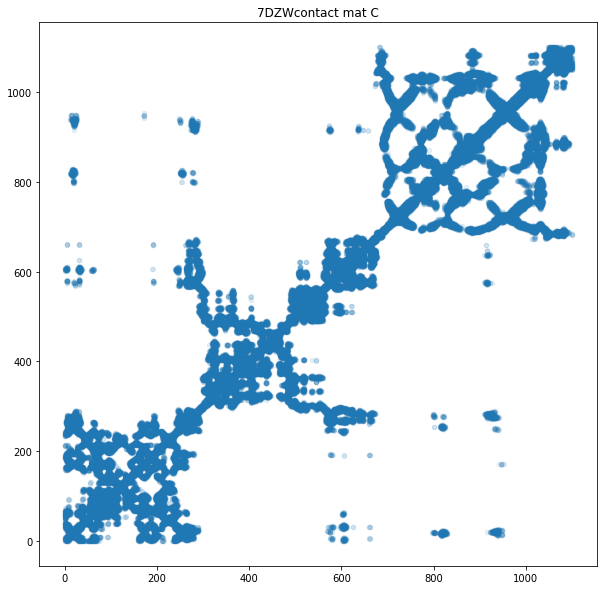

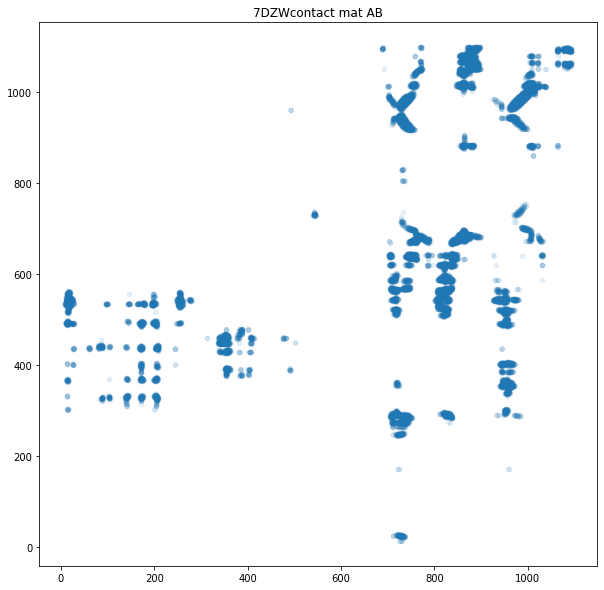

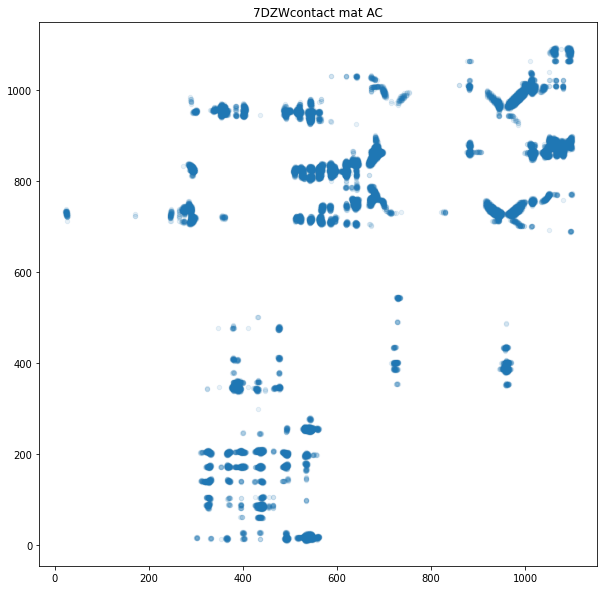

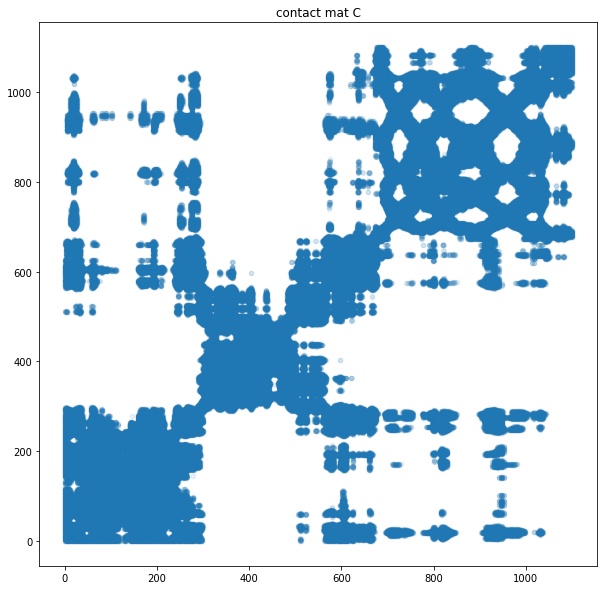

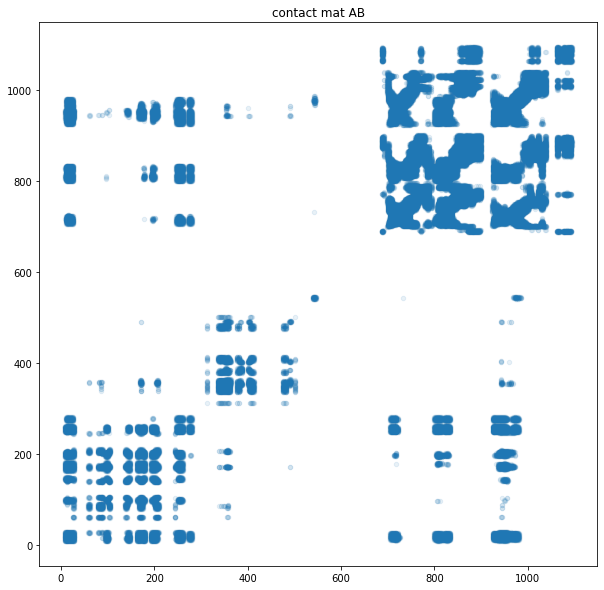

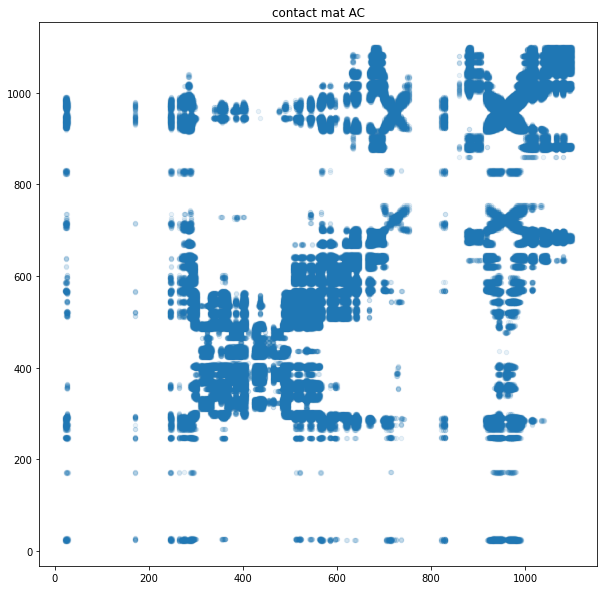

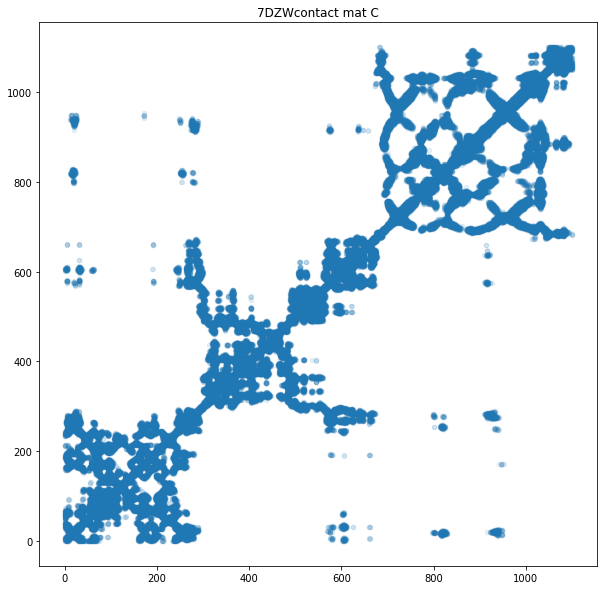

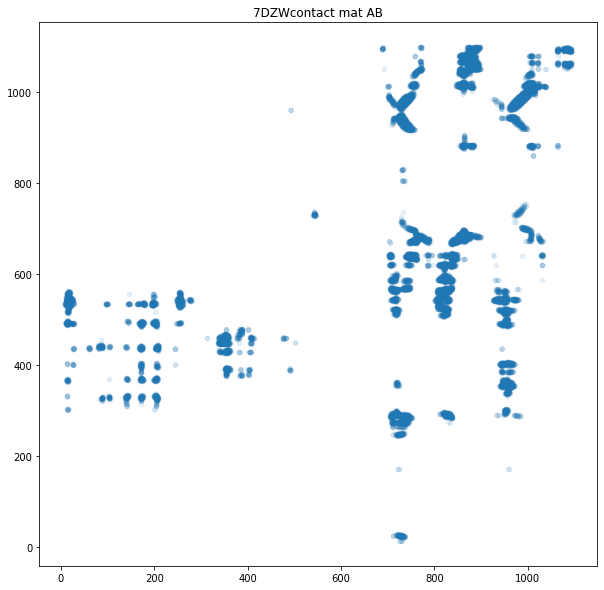

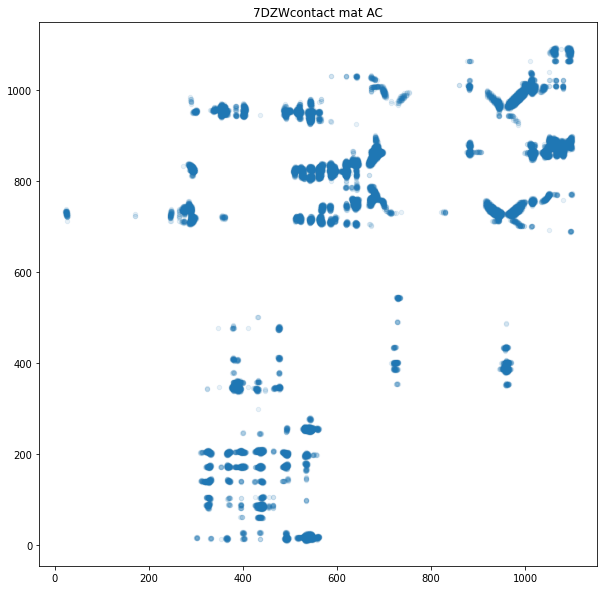

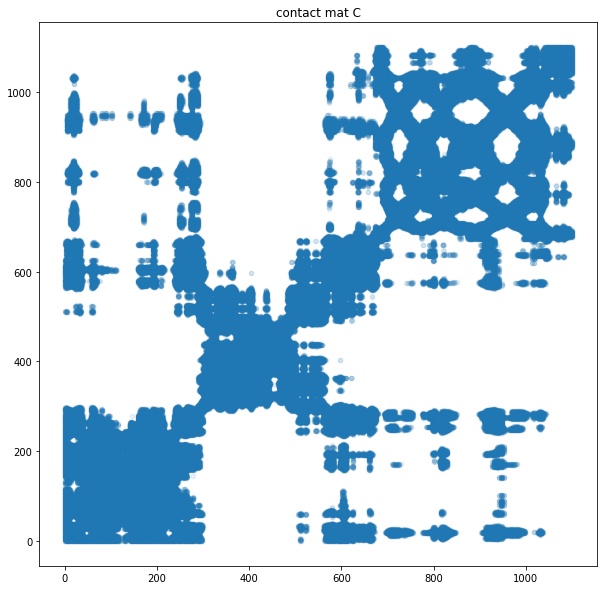

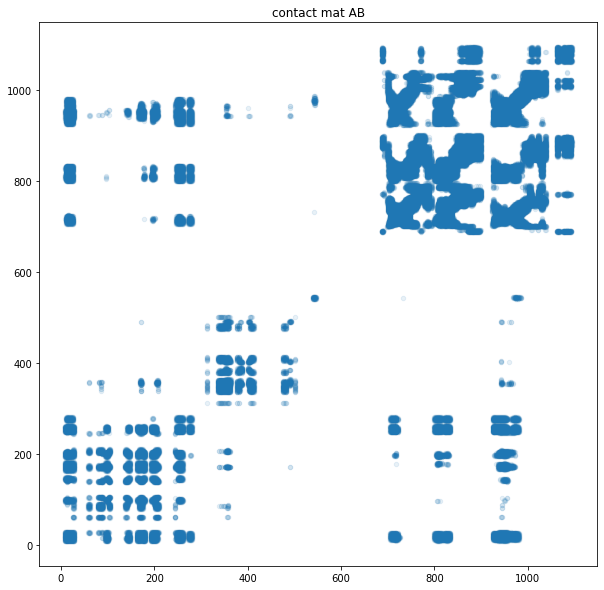

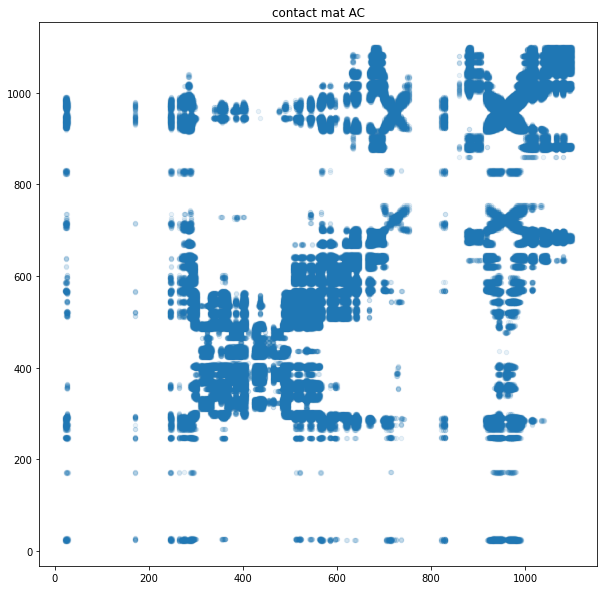

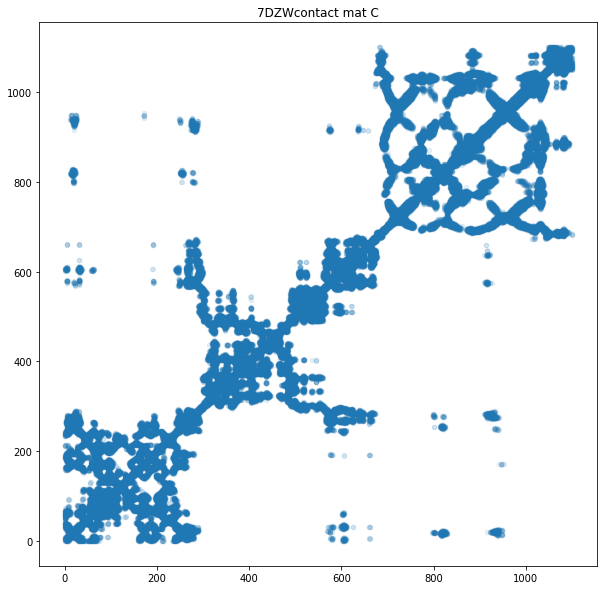

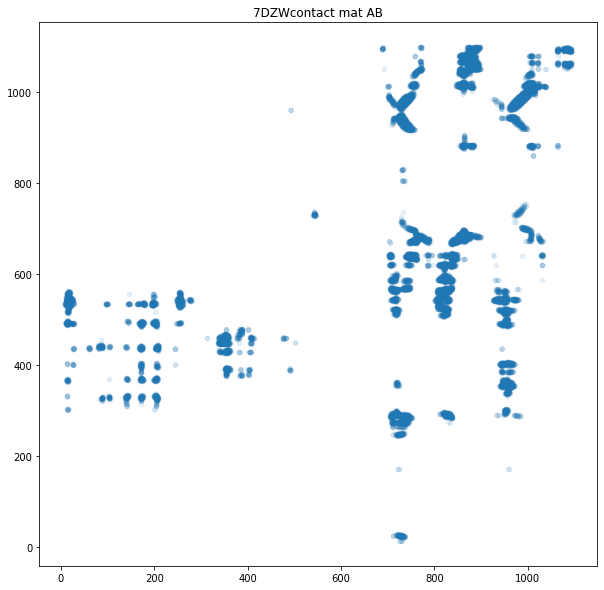

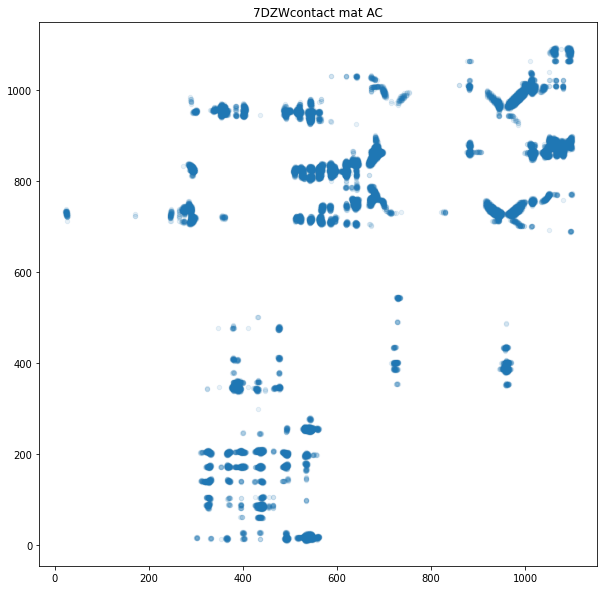

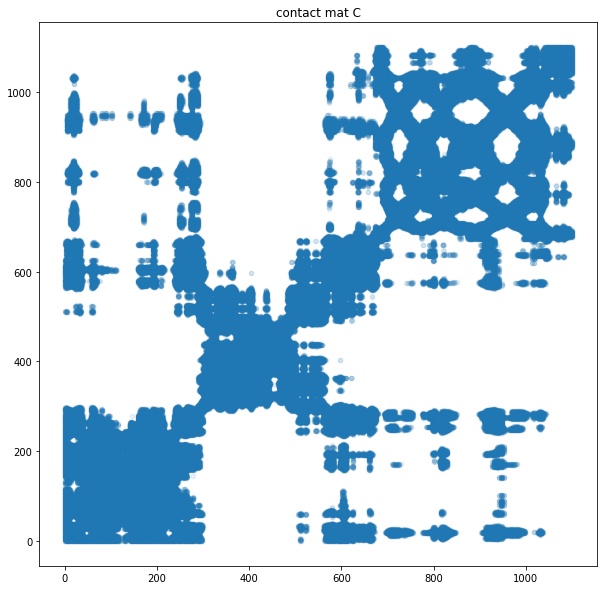

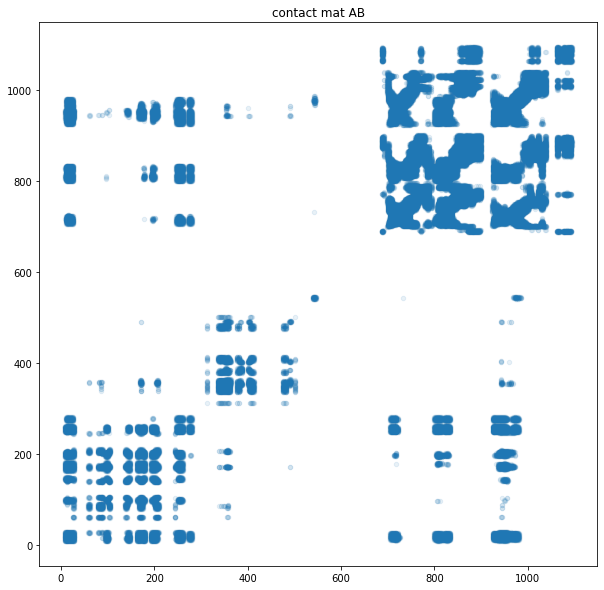

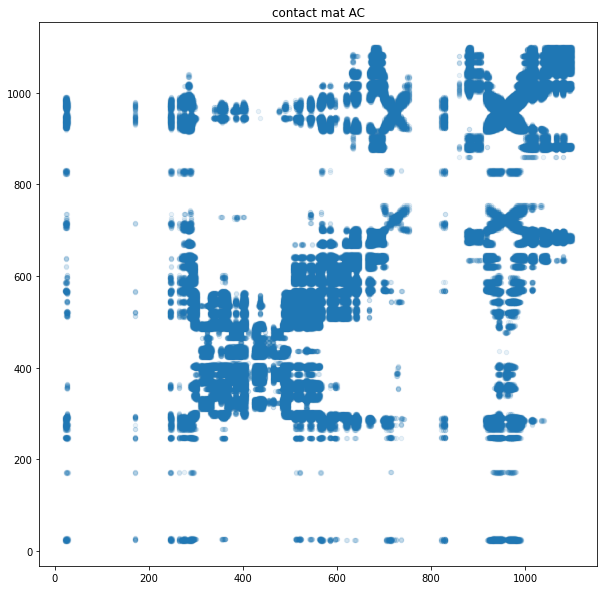

In [36]:
import copy
angstrom_cutoff = 15
show_contacts = True

if overwrite_connect == True:
    @dask.delayed( nout = 2)
    def define_contacts(mat , angstrom_cutoff = 15 ):
        subthresh = copy.deepcopy(mat)
        subthresh[ subthresh < angstrom_cutoff ] = 1 
        subthresh[ subthresh > angstrom_cutoff ] = 0 
        np.fill_diagonal(subthresh , 0)
        subthresh = subthresh[0:subthresh.shape[0]-20,0:subthresh.shape[1]-20]
        connected = np.dot(subthresh,subthresh.T)
        return subthresh,connected

    subthresh_thresh ={}
    subthresh_connected ={}

    chain_equivalencies={}
    for m in distmats:
        for chain in distmats[m]:
            if m not in subthresh_thresh:
                subthresh_thresh[m]={}
                subthresh_connected[m] ={}

                for chain in distmats[m]:
                    subthresh, connected = define_contacts(distmats[m][chain] , angstrom_cutoff  )
                    subthresh_thresh[m][chain] = subthresh
                    subthresh_connected[m][chain] = connected
            subthresh_thresh[m] = dict( zip ( subthresh_thresh[m].keys() , dask.compute( * list(subthresh_thresh[m].values() ))))
            subthresh_connected[m] = dict( zip ( subthresh_connected[m].keys() , dask.compute( * list(subthresh_connected[m].values() ))))

            if show_contacts == True:
                for chain in subthresh_thresh[m]:
                    subthresh = subthresh_thresh[m][chain]

                    plt.figure(figsize=(10,10) )
                    plt.title(m +'contact mat '+ ''.join(chain) )
                    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                    plt.show()

                for chain in subthresh_connected[m]:
                    connected = subthresh_connected[m][chain]
                    plt.figure(figsize=(10,10) )
                    plt.title('contact mat '+ ''.join(chain) )
                    plt.scatter( np.nonzero(connected)[0] ,np.nonzero(connected)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                    plt.show()

    with open(modeldir + 'contactmaps' , 'wb') as connectout:
        connectout.write(pickle.dumps((subthresh_thresh , subthresh_connected)))
else:
    with open(modeldir + 'contactmaps' , 'rb') as connectout:
        subthresh_thresh , subthresh_connected = pickle.loads(connectout.read())

In [75]:
#minhash all event cols with more than #nthresh events
#search top 10 for each col
allpairs = {}

print(subthresh_thresh)
print(subthresh_connected)

for code in subthresh_thresh:
    if code not in allpairs:
        allpairs[code] = {}
    for chainpair in subthresh_thresh[code]:
        pairs = np.nonzero(subthresh_thresh[code][chainpair])
        pairset = set([ ( pairs[0][i] , pairs[1][i] ) for i in range(pairs[0].shape[0]) ])
        
        allpairs[code][chainpair] = pairset

{'7DZW': {'C': array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float32), ('A', 'B'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), ('A', 'C'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}
{'7DZW': {'C': array([[73., 65., 62., ...,  0.,  0.,  0.],
       [65., 83., 77., ...,  0.,  0.,  0.],
       [62., 77., 94., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 32

In [38]:
def tree2Single_sparse_graph_updown(tree):
    N = len(tree.nodes())
    #mimic the fitch algo
    #propagate up and down in separate graphs
    index_up = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    index_down = np.vstack([ [c.matrow, n.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    
    
    
    connectmat_up = scipy.sparse.lil_matrix(( N ,  N ) )
    
    connectmat_down = scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_up[index_up[:,0],index_up[:,1]] = 1 
    
    
    connectmat_down[index_down[:,0],index_down[:,1]] = 1 
    diag = [[n,n] for n in range(N)]
    connectmat_diag=scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_diag[diag,diag] = 1 
    
    ntime = np.array([ n.distance_from_root() for n in tree.nodes()])
    mtime = np.amax(ntime)
    
    ntime/=mtime
    levels = np.array([ n.level() for n in tree.nodes() ] , dtype='double')
    mlevel = np.amax(levels)
    levels/=mlevel
    
    
    
    edgelens= np.array([ n.edge_length for n in tree.nodes() ] , dtype='double')
    
    
    template_features = np.stack([ntime ,  edgelens , levels ]).T    
    
    return connectmat_up, connectmat_down, connectmat_diag, template_features

def sparse2pairs(sparsemat, matrows = None):
    if matrows :
        sparsemat = sparsemat[matrows,:]
        sparsemat = sparsemat[:,matrows]
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])



In [39]:
#tree sector based aggregation
#label sectors

def process_node_down(node, sector = 0, breakpt = 10 , total = 0 ):
    node.sector = sector
    if sector == 0 :
        global count
        count = 0
    total += len(node.child_nodes())
    for i,child in enumerate(node.child_nodes()):
        if total > breakpt:
            if len(child.child_nodes())>0:
                #new sector w new total
                count+=1
                process_node_down(child, count , total = 0 , breakpt = breakpt)
            else:
                #leaf
                process_node_down(child, count , total = 0 , breakpt = breakpt)
        else:
            process_node_down(child, count , total = total , breakpt = breakpt)

    
def get_sectors(tree, breakpt = 10):
    process_node_down( tree.seed_node , sector = 0, breakpt = breakpt )
    row = [n.matrow for n in tree.nodes()]
    col = [n.sector for n in tree.nodes()]
    data = np.ones((len(row)))
    sectormat = scipy.sparse.csc_matrix( (data,(row,col)) )
    return sectormat

for i,l in enumerate(tree.nodes()):
    l.sum_lengths = None
for i,l in enumerate(tree.leaf_nodes()):
    l.sum_lengths = 1


In [40]:
compile_templates = False
compile_sectors = True

if compile_templates == True:
    #check correlation of graphnet score w jaccard
    connectmat_up, connectmat_down, connectmat_diag, template_features = tree2Single_sparse_graph_updown(tree)
    print(connectmat_up.shape)
    print(template_features.shape)
    with open('template_features.pkl' , 'wb') as templateout:
        templateout.write(pickle.dumps([connectmat_up, connectmat_down, connectmat_diag, template_features]))
    
else:
    with open('template_features.pkl' , 'rb') as template_in:
        connectmat_up, connectmat_down, connectmat_diag, template_features = pickle.loads(template_in.read())

if compile_sectors == True:        
    sectormat = get_sectors(tree, breakpt = 500 )
    print(sectormat.shape)

    with open('sectormat.pkl' , 'wb' ) as sectorout:
        sectorout.write(pickle.dumps(sectormat))
        
else:
    with open('sectormat.pkl' , 'rb') as sector_in:
        sectormat = pickle.loads(sector_in.read())
    

(997916, 1854)


In [41]:
print('template features', template_features )
print( 'sectors', sectormat)

template features [[0.                nan 0.        ]
 [0.         0.         0.00023089]
 [0.         0.         0.00023089]
 ...
 [0.         0.         0.00023089]
 [0.         0.         0.00023089]
 [0.         0.         0.00023089]]
sectors   (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 0)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 0)	1.0
  (24, 0)	1.0
  :	:
  (997891, 1853)	1.0
  (997892, 1853)	1.0
  (997893, 1853)	1.0
  (997894, 1853)	1.0
  (997895, 1853)	1.0
  (997896, 1853)	1.0
  (997897, 1853)	1.0
  (997898, 1853)	1.0
  (997899, 1853)	1.0
  (997900, 1853)	1.0
  (997901, 1853)	1.0
  (997902, 1853)	1.0
  (997903, 1853)	1.0
  (997904, 1853)	1.0
  (997905, 1853)	1.0
  (997906, 1853)	1.0
  (997907, 1853)	1.0
  (997908, 1853)	1.0
  (997909, 1853)	1.0
  (9979

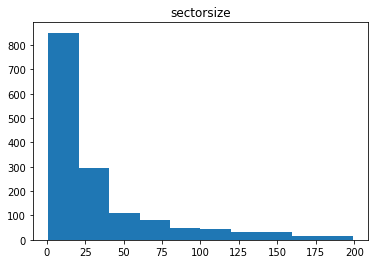

In [42]:

sectorsum = sectormat.sum(axis = 0)
plt.hist(sectorsum[sectorsum < 200 ].flat)
plt.title('sectorsize')
plt.show()

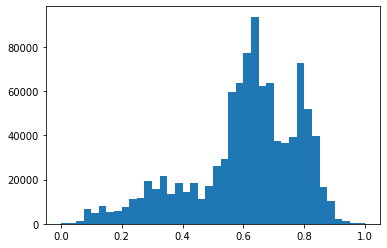

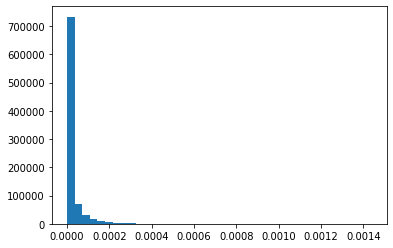

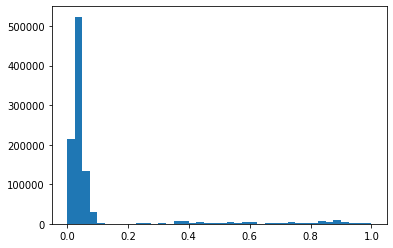

In [72]:
for i in range(template_features.shape[1]):
    plt.hist(np.array(template_features[:,i].data).flat, bins = 40)
    plt.show()


In [44]:
#get a hist of sector size



In [73]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


16333.48828125


In [74]:
def ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss ):
    data = HeteroData()
    #add input data
    data['phylonodes_up'].x = torch.tensor( subfeatures )
    data['phylonodes_down'].x =torch.tensor( subfeatures )
    data['sectornode'].x =torch.tensor(  np.zeros((1,1)) )
    #up down fitch net
    data['phylonodes_up', 'phylolink_up', 'phylonodes_up'].edge_index = torch.tensor(connect_up ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down', 'phylonodes_down'].edge_index = torch.tensor(connect_down ,  dtype=torch.long )             
    data['phylonodes_up', 'phylolink_up_down', 'phylonodes_down'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down_up', 'phylonodes_up'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )
    #pooling connections
    data['phylonodes_down', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )
    data['phylonodes_up', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )

    #pooling connections
    data['sectornode',  'informs', 'phylonodes_down' ].edge_index = torch.tensor(overview_rev,  dtype=torch.long )
    data['sectornode',  'informs', 'phylonodes_up'].edge_index = torch.tensor(overview_rev ,  dtype=torch.long )
    
    #categories are intra or interprotein contacts or nothing
    if intra == True:
        cateforical = np.array([0,1])
    else:
        cateforical = np.array([1,0])
    data['phylonodes_down'].y =torch.tensor( np.ones((subfeatures.shape[0],1) ) *toss ,  dtype=torch.long )
    data['phylonodes_up'].y =torch.tensor( np.ones((subfeatures.shape[0],1)) * toss ,  dtype=torch.long )
    #todo change to categorical
    data['sectornode'].y =torch.tensor(  np.ones((1,1))*toss  ,  dtype=torch.long )
    data = T.AddSelfLoops()(data)
    data = T.NormalizeFeatures()(data)
    return data


def create_data_updown_transitions(intra ,pairs, AA_tensor, NT_tensor, sectormat, connectmat_up, connectmat_down, connectmat_diag, 
 template_features , posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = True, loop= True , sectors_chunk = True ):
    #upward and downward connected phylo nodes
    Nsectors = 0
    Nnodes = 0
    allcols =list( np.arange(NT_tensor.shape[1]) )
    while True:
        toss = scipy.stats.bernoulli.rvs(posi_percent, loc=0, size=1, random_state=None)
        label = np.ones((1,1))*toss
    
        if verbose == True:
            print('posi/nega',toss)
            print('posi/nega',label)

        if toss == 0:
            col1 = random.choice(allcols)
            col2 = col1
            while col1 == col2 and (col1,col2) not in pairs:
                col2 = random.choice(allcols)
            labels = np.zeros((template_features.shape[0],))           
        else:
            #positive sample
            pairtuple = random.choice(pairs)
            col1 = pairtuple[0]
            col2 = pairtuple[1]
        if verbose == True:
            print(col1, col2)

        #select coev features
        nodeAAfeatures = sparse.stack( [AA_tensor[:,col1,:] ,AA_tensor[:,col2,:] ] , axis = 2  ).reshape((AA_tensor.shape[0],-1)).to_scipy_sparse()
        nt_cols = []
        for pos in [0,1,2]:
            nodeNTfeatures = sparse.stack( [NT_tensor[:,col1,pos,:] ,NT_tensor[:, col2,pos,:] ] , axis = 2)
            nt_cols.append(nodeNTfeatures.reshape((nodeNTfeatures.shape[0],-1)).to_scipy_sparse() )
        nodefeatures = scipy.sparse.hstack([nodeAAfeatures,scipy.sparse.coo_matrix(template_features) ]+nt_cols)
        
        
        #slice the features into sectors and yield sectors
        if sectors_chunk == True:
            nodefeatures = sparse.COO(nodefeatures)
            count = 0
            sectors = list(np.arange(sectormat.shape[1])) 
            for sample in range(nsamples):
                sector = random.choice(sectors)
                rows = scipy.sparse.find(sectormat[:,sector])[0]
                if rows.shape[0]> min_nodes:
                    count +=1
                    if verbose == True:
                        print('rows',rows.shape)

                #node features
                subfeatures = nodefeatures[rows,:].todense()
                #phylonode connections
                sub_connect_up = connectmat_up[rows,:]
                sub_connect_up = sub_connect_up[:,rows]
                connect_up = sparse2pairs(sub_connect_up)
                sub_connect_down = connectmat_down[rows,:]
                sub_connect_down = sub_connect_down[:,rows]
                connect_down = sparse2pairs(sub_connect_down)
                sub_diag = connectmat_diag[rows,:]
                sub_diag = sub_diag[:,rows]
                sub_diag = sparse2pairs(sub_diag)
                #aggregator node
                overview = scipy.sparse.lil_matrix( (subfeatures.shape[0], 2 ) )
                overview[:,0] = 1
                overview_rev = sparse2pairs(overview.T)
                overview = sparse2pairs(overview)
                data = ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss )
                if q:
                    q.put(data)
                else:
                    yield data
        else:
            #yield the entire graph
            #not working with sparse yet...
            #node features
            #change to torch sparse
            values = nodefeatures.data
            indices = np.vstack((nodefeatures.row, nodefeatures.col))

            i = torch.LongTensor(indices)
            v = torch.FloatTensor(values)
            shape = nodefeatures.shape
            subfeatures = torch.sparse_coo_tensor(i, v, torch.Size(shape))
            subfeatures = subfeatures.coalesce()
            #phylonode connections
            sub_connect_up = connectmat_up
            connect_up = sparse2pairs(sub_connect_up)
            sub_connect_down = connectmat_down
            connect_down = sparse2pairs(sub_connect_down)
            sub_diag = connectmat_diag
            sub_diag = sparse2pairs(sub_diag)
            #aggregator node
            overview = scipy.sparse.lil_matrix( (subfeatures.shape[0], 2 ) )
            overview[:,0] = 1
            overview_rev = sparse2pairs(overview.T)
            overview = sparse2pairs(overview)
            data = ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss )
            if q:
                q.put(data)
            else:
                yield data
                

In [68]:
def ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss ):
    data = HeteroData()
    #add input data
    data['phylonodes_up'].x = torch.tensor( subfeatures )
    data['phylonodes_down'].x =torch.tensor( subfeatures )
    data['sectornode'].x =torch.tensor(  np.zeros((1,1)) )
    #up down fitch net
    data['phylonodes_up', 'phylolink_up', 'phylonodes_up'].edge_index = torch.tensor(connect_up ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down', 'phylonodes_down'].edge_index = torch.tensor(connect_down ,  dtype=torch.long )             
    data['phylonodes_up', 'phylolink_up_down', 'phylonodes_down'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down_up', 'phylonodes_up'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )

    #pooling connections
    data['phylonodes_down', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )
    data['phylonodes_up', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )

    #pooling connections
    data['sectornode',  'informs', 'phylonodes_down' ].edge_index = torch.tensor(overview_rev,  dtype=torch.long )
    data['sectornode',  'informs', 'phylonodes_up'].edge_index = torch.tensor(overview_rev ,  dtype=torch.long )
    #categories are intra or interprotein contacts or nothing
    if intra == True:
        cateforical = np.array([0,1])
    else:
        cateforical = np.array([1,0])
    data['phylonodes_down'].y =torch.tensor( np.ones((subfeatures.shape[0],1) ) *toss ,  dtype=torch.long )
    data['phylonodes_up'].y =torch.tensor( np.ones((subfeatures.shape[0],1)) * toss ,  dtype=torch.long )
    #todo change to categorical
    data['sectornode'].y =torch.tensor(  np.ones((1,1))*toss  ,  dtype=torch.long )
    data = T.AddSelfLoops()(data)
    data = T.NormalizeFeatures()(data)
    return data

def yield_tosses(posi_percent = .5):
    while True:
        toss = scipy.stats.bernoulli.rvs(posi_percent, loc=0, size=1, random_state=None)
        yield toss



def gen_sample(toss ,pairs, AA_tensor, NT_tensor, sectormat, connectmat_up, connectmat_down, connectmat_diag, 
     template_features , posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True , intra = True ):
    #generate a few samples of subgraphs from a column pair
    label = np.ones((1,1))*toss
    allcols =list( np.arange(NT_tensor.shape[1]) )
    if toss == 0:
        col1 = random.choice(allcols)
        col2 = col1
        while col1 == col2 and (col1,col2) not in pairs:
            col2 = random.choice(allcols)
        labels = np.zeros((template_features.shape[0],))           
    else:
        #positive sample
        pairtuple = random.choice(pairs)
        col1 = pairtuple[0]
        col2 = pairtuple[1]
    if verbose == True:
        print(col1, col2)
    #select coev features
    nodeAAfeatures = sparse.stack( [AA_tensor[:,col1,:] ,AA_tensor[:,col2,:] ] , axis = 2  ).reshape((AA_tensor.shape[0],-1))
    nt_cols = []
    for pos in [0,1,2]:
        nodeNTfeatures = sparse.stack( [NT_tensor[:,col1,pos,:] ,NT_tensor[:, col2,pos,:] ] , axis = 2)
        nt_cols.append(nodeNTfeatures.reshape((nodeNTfeatures.shape[0],-1)) )
    
    features = [sparse.COO(template_features),nodeAAfeatures]+nt_cols
    features = [mat.to_scipy_sparse() for mat in features]
    nodefeatures = sparse.COO(scipy.sparse.hstack( features ))
    #slice the features into sectors and yield sectors
    sectors = list(np.arange(sectormat.shape[1])) 
    samples =[]
    while len( samples ) < nsamples:
        sector = random.choice(sectors)
        rows = scipy.sparse.find(sectormat[:,sector])[0]
        if len(rows ) > min_nodes:
            #node features
            subfeatures = nodefeatures[rows,:].todense()
            #phylonode connections
            sub_connect_up = connectmat_up[rows,:]
            sub_connect_up = sub_connect_up[:,rows]
            connect_up = sparse2pairs(sub_connect_up)
            sub_connect_down = connectmat_down[rows,:]
            sub_connect_down = sub_connect_down[:,rows]
            connect_down = sparse2pairs(sub_connect_down)
            sub_diag = connectmat_diag[rows,:]
            sub_diag = sub_diag[:,rows]
            sub_diag = sparse2pairs(sub_diag)
            #aggregator node
            overview = scipy.sparse.lil_matrix( (subfeatures.shape[0], 2 ) )
            overview[:,0] = 1
            overview_rev = sparse2pairs(overview.T)
            overview = sparse2pairs(overview)
            data = ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss )
            samples.append(data)
    return samples

def create_data_updown_transitions(client ,pairs, AA_tensor, NT_tensor, sectormat, connectmat_up, connectmat_down, connectmat_diag, 
 template_features , posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = True, loop= True , sectors_chunk = True ):

    #map
    tossgen = yield_tosses(posi_percent)
    futures = client.map(
        
        gen_sample, tosses , key=None, workers=None, retries=None, 
        resources=None, priority=0, allow_other_workers=False, fifo_timeout='100 ms', actor=False, 
        actors=False, pure=None, 
        batch_size= 10 ,                        
        
        #func args
        pairs= pairs , 
        AA_tensor= AA_tensor, 
        NT_tensor=NT_tensor,
        sectormat=sectormat,
        connectmat_up=connectmat_up,
        connectmat_down=connectmat_down,
        connectmat_diag=connectmat_diag,
        template_features=template_features,
        posi_percent = .5 , 
        nsamples = 10 , 
        min_nodes = 100,  
        q = None , 
        iolock= None,                   
        verbose = True, 
        loop= True ,
        sectors_chunk = True
         )
    
    #iterate over res as finished
    for future in as_completed(futures):
        samples = future.result()
        for data in samples:
            yield data

def create_data_updown_transitions_single( pairs, AA_tensor, NT_tensor, sectormat, connectmat_up, connectmat_down, connectmat_diag, 
 template_features , posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = True, loop= True , sectors_chunk = True ):

    #map
    tossgen = yield_tosses(posi_percent)
    for toss in tossgen:
        samples = gen_sample( toss , pairs, AA_tensor, NT_tensor, sectormat, connectmat_up, connectmat_down, connectmat_diag, template_features 
                    , posi_percent = .5 ,  q = None , iolock= None,  verbose = verbose, loop= True  )
        #iterate over res as finished
        for data in samples:
            yield data

In [48]:
#create reduced alphabet mapping
#AA transitions

murphy12 = [('L','V','I','M'), ('C'), ('A'), ('G'), ('S','T'), ('P'), ('F','Y'), ('W'), ('E','Q'), ('D','N'), ('K','R'), ('H') ]
murphy12 = { c:i for i,cset in enumerate(murphy12) for c in cset   }
print('murphy12',murphy12)

ProteinAlphabet = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
allowed_AA_transitions = [ c1+c2 for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2]

print('ntransitions' ,len(set(allowed_AA_transitions)))
new_transitions = [ (murphy12[c1],murphy12[c2]) for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2  ]
new_transitions = { tup:i for i,tup in enumerate(set(new_transitions)) }
print('nmurphy transitions' , len(set(new_transitions)))
print(allowed_AA_transitions[0:100] , '...etc...')
transitiondict_AA = {  c : i  for i,c in enumerate( allowed_AA_transitions )  }
rev_transitiondict_AA = dict( zip(transitiondict_AA.values(), transitiondict_AA.keys()))


murphy12 {'L': 0, 'V': 0, 'I': 0, 'M': 0, 'C': 1, 'A': 2, 'G': 3, 'S': 4, 'T': 4, 'P': 5, 'F': 6, 'Y': 6, 'W': 7, 'E': 8, 'Q': 8, 'D': 9, 'N': 9, 'K': 10, 'R': 10, 'H': 11}
ntransitions 380
nmurphy transitions 138
['AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AK', 'AL', 'AM', 'AN', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AV', 'AW', 'AY', 'CA', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CV', 'CW', 'CY', 'DA', 'DC', 'DE', 'DF', 'DG', 'DH', 'DI', 'DK', 'DL', 'DM', 'DN', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DV', 'DW', 'DY', 'EA', 'EC', 'ED', 'EF', 'EG', 'EH', 'EI', 'EK', 'EL', 'EM', 'EN', 'EP', 'EQ', 'ER', 'ES', 'ET', 'EV', 'EW', 'EY', 'FA', 'FC', 'FD', 'FE', 'FG', 'FH', 'FI', 'FK', 'FL', 'FM', 'FN', 'FP', 'FQ', 'FR', 'FS', 'FT', 'FV', 'FW', 'FY', 'GA', 'GC', 'GD', 'GE', 'GF'] ...etc...


In [49]:

#reduce alphabet to reduce AA transition dimensionality
def restrictAA_transitions(AAmat, rev_transitiondict_AA, murphy12 , new_transitions , restricted_transitions = 138 , verbose = True ):
    restricted = None
    for z in range(AAmat.shape[2]):
        
        transition = rev_transitiondict_AA[z]
        new_transition = new_transitions[ (murphy12[transition[0]] , murphy12[transition[1]] )]
        data = AAmat[:,:,z].data
        coords =  AAmat[:,:,z].coords
        if coords.shape[1]>0:    
            newcoords = np.vstack( [coords, np.ones((1,coords.shape[1]))*new_transition]).astype('int')
            if restricted is not None:
                restricted  += sparse.COO( coords =  newcoords , data = data
                                            , shape = (AAmat.shape[0] , AAmat.shape[1] , restricted_transitions )  )
            else:
                restricted  =  sparse.COO( coords = newcoords , data = data  
                                            , shape = (AAmat.shape[0] , AAmat.shape[1] , restricted_transitions )  )
    return restricted


In [50]:
###rewrite codon compilation for sparse
import sparse

restrictAA = True
def retcodons( AAmat , NTmat, qstart, qend, verbose = True ):
    #aa mutations for each pos
    AAmat_sub = sparse.stack(  [ AAmat[ : , codon:codon+2 , : ].sum(axis = 1) for codon in range(qstart-1, qend-1 , 3 )  ] , axis = 1 )    
    #add the frames for each in a stack 
    if verbose == True:
        print('done AA')
    NTmat_sub = sparse.stack([  sparse.stack( [ NTmat[:, codon + frame , : ] for frame in [0,1,2] ] , axis = 1 )  for codon in range(qstart-1, qend-1 , 3 ) ] , axis = 1)
    if verbose == True:
        print('done NT')
    return AAmat_sub , NTmat_sub
print(annotation)
structmats = {}
start_stop ={}
print(nucleotide_mutation)
print(AA_mutation)

for i,row  in annotation.iterrows():
    print(row.qstart)
    if row.struct not in structmats:
        structmats[row.struct]={}    
    if (row.qstart , row.qend) not in start_stop:
        structmats[row.struct][row.chain ] = retcodons(AA_mutation, nucleotide_mutation  , row.qstart , row.qend)
        if restrictAA == True:
            structmats[row.struct][row.chain ] = ( restrictAA_transitions(structmats[row.struct][row.chain ][0] , rev_transitiondict_AA, murphy12 , new_transitions , restricted_transitions = 138 ) , structmats[row.struct][row.chain ][1] )
        start_stop[(row.qstart , row.qend)] = structmats[row.struct ][ row.chain ]
    else: 
        structmats[row.struct][row.chain ] = start_stop[(row.qstart , row.qend)]
        

  qseqid                                             sseqid   qlen  slen  \
0    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   

   qstart   qend  qframe  evalue struct chain  
0   21604  24966       1     0.0   7DZW     C  
1   21604  24966       1     0.0   7DZW     B  
2   21604  24966       1     0.0   7DZW     A  
<COO: shape=(997916, 29809, 12), dtype=float64, nnz=2075009, fill_value=0.0>
<COO: shape=(997916, 29809, 380), dtype=float64, nnz=1338566, fill_value=0.0>
21604
done AA
done NT
21604
21604


In [54]:
print(structmats)

{'7DZW': {'C': (<COO: shape=(997916, 1121, 138), dtype=float64, nnz=371390, fill_value=0.0>, <COO: shape=(997916, 1121, 3, 12), dtype=float64, nnz=401917, fill_value=0.0>), 'B': (<COO: shape=(997916, 1121, 138), dtype=float64, nnz=371390, fill_value=0.0>, <COO: shape=(997916, 1121, 3, 12), dtype=float64, nnz=401917, fill_value=0.0>), 'A': (<COO: shape=(997916, 1121, 138), dtype=float64, nnz=371390, fill_value=0.0>, <COO: shape=(997916, 1121, 3, 12), dtype=float64, nnz=401917, fill_value=0.0>)}}


In [55]:
template_features = sparse.COO(template_features)
sampleGEN = create_data_updown_transitions_single( pairs, structmats['7DZW']['C'][0] , structmats['7DZW']['C'][1] , sectormat, connectmat_up, connectmat_down, connectmat_diag, 
 template_features , posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True )

In [57]:
data = next( sampleGEN )
print(data)

StopIteration: 

In [58]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


12406.35546875


In [59]:
print(structmats)

{'7DZW': {'C': (<COO: shape=(997916, 1121, 138), dtype=float64, nnz=371390, fill_value=0.0>, <COO: shape=(997916, 1121, 3, 12), dtype=float64, nnz=401917, fill_value=0.0>), 'B': (<COO: shape=(997916, 1121, 138), dtype=float64, nnz=371390, fill_value=0.0>, <COO: shape=(997916, 1121, 3, 12), dtype=float64, nnz=401917, fill_value=0.0>), 'A': (<COO: shape=(997916, 1121, 138), dtype=float64, nnz=371390, fill_value=0.0>, <COO: shape=(997916, 1121, 3, 12), dtype=float64, nnz=401917, fill_value=0.0>)}}


In [60]:
print(subthresh_connected['7DZW'])

{'C': array([[73., 65., 62., ...,  0.,  0.,  0.],
       [65., 83., 77., ...,  0.,  0.,  0.],
       [62., 77., 94., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 32., 31., 22.],
       [ 0.,  0.,  0., ..., 31., 39., 25.],
       [ 0.,  0.,  0., ..., 22., 25., 26.]], dtype=float32), ('A', 'B'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), ('A', 'C'): array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 32., 26., 21.],
       [ 0.,  0.,  0., ..., 26., 33., 27.],
       [ 0.,  0.,  0., ..., 21., 27., 29.]], dtype=float32)}


In [61]:
from torch_geometric.nn import HeteroConv , SAGEConv, Linear , ResGatedGraphConv , GATv2Conv , TransformerConv , MFConv , FiLMConv 
import torch_geometric.transforms as T

#without sectornode
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        self.lins =  torch.nn.ModuleList()
        self.lins2 =  torch.nn.ModuleList()
        
        for i in range(num_layers):
            conv = HeteroConv({
                ('phylonodes_up', 'phylolink_up', 'phylonodes_up'):MFConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down', 'phylonodes_down'):MFConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down_up', 'phylonodes_up'):MFConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'phylolink_up_down', 'phylonodes_down'):MFConv((-1,-1),  int( hidden_channels) ), 
                ('phylonodes_down', 'informs', 'sectornode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'informs', 'sectornode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('sectornode', 'informs', 'phylonodes_down'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('sectornode', 'informs', 'phylonodes_up'):TransformerConv((-1,-1),  int( hidden_channels) ),
            } , aggr='sum')
            self.convs.append(conv)
            for vectype in  ['phylonodes_up', 'phylonodes_down' , 'sectornode'  ]:
                lin1 = Linear(-1 , int( hidden_channels))
                self.lins.append( lin1 )
                
            print( 'hidden units' , int( hidden_channels) )
            print( 'layer' , i )

        for vectype in ['phylonodes_up', 'phylonodes_down' , 'sectornode' ]:
            lin2 = Linear(-1 , out_channels)
            self.lins2.append( lin2 ) 

    
    def forward(self, x_dict, edge_index_dict):
        lins = iter(self.lins)
        for i,conv in enumerate(self.convs):
            x_dict = conv(x_dict , edge_index_dict)
            x_dict = {key: F.dropout(x , p = .1 , training = self.training ) for key, x in x_dict.items()}

            for key, x in x_dict.items():
                x_dict[key] = next(lins)(x)
        lins2 = iter(self.lins2)
        
        for key, x in x_dict.items():
            x_dict[key] =  next(lins2)(x)
        
        return {key: F.tanh(x) for key, x in x_dict.items()}
        #return x_dict

model = HeteroGCN(hidden_channels=40 , out_channels=1, num_layers=5)
model = model.double()
model = model.to(device)


hidden units 40
layer 0
hidden units 40
layer 1
hidden units 40
layer 2
hidden units 40
layer 3
hidden units 40
layer 4


In [62]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
with torch.no_grad():  # Initialize lazy modules.
    data = data.to(device)
    out = model(data.x_dict , data.edge_index_dict)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [70]:
import warnings
lastauc = 0
epochs = 1000
#iterate over structs
model = model.to(device)

def calc_metrics(truths,preds,label = ''):
    truth = np.hstack(truths).ravel()
    predy = np.hstack(preds).ravel()
    print(truth.shape, predy.shape)
    fpr, tpr, _ = roc_curve(  truth  ,predy )
    auc_s = auc(fpr, tpr)
    print(label,auc_s)

        
        
with warnings.catch_warnings():
    model.train()
    warnings.simplefilter("ignore")
    #iterate over chain pairs
    #create a chunk generator for a chain pair
    #iterate over graph chunks
    for struct in subthresh_connected:
        for i,chains in enumerate(subthresh_connected[struct]):
            
            
            print(struct,chains)
            
            AA_tensor , NT_tensor = structmats[struct][chains]
            intra = len(chains)>1
            pairs = list(allpairs[struct][chains])
            
            print('creating generator ' )
            #dask parallel gen of data on the fly
            
            #sampleGEN = create_data_updown_transitions_single( pairs, structmats[struct][chains][0] , structmats[struct][chains][1] , sectormat, connectmat_up, connectmat_down, connectmat_diag, 
            #template_features , posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True )
            
            
            sampleGEN = create_data_updown_transitions( client , pairs, structmats[struct][chains][0] , structmats[struct][chains][1] , sectormat, connectmat_up, connectmat_down, connectmat_diag, 
            template_features , posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True )
            
            
            print('done init')
            truths = []
            preds = []

            truths_n = []
            preds_n = []

            losses1 =[]
            losses2 = []
            losses3 = []
            
            for k,data in enumerate(sampleGEN):
                if k < 100 and k % 10 == 0 :
                    print(k)
                data = data.to(device)            
                out = model(data.x_dict ,data.edge_index_dict)
                optimizer.zero_grad()
                loss1 =  F.mse_loss(out['phylonodes_up'], data['phylonodes_up'].y.double())
                loss2 =  F.mse_loss(out['phylonodes_down'], data['phylonodes_down'].y.double())
                loss3 =  F.mse_loss(out['sectornode'], data['sectornode'].y.double())
                loss = loss1 + loss2+ loss3
                loss.backward()
                optimizer.step()
                losses3.append(float(loss3.to('cpu')))
                losses2.append(float(loss2.to('cpu')))
                losses1.append(float(loss1.to('cpu')))

                truth = data['sectornode']['y'][:].to('cpu').detach().numpy()
                predy =  out['sectornode'][:].to('cpu').detach().numpy()
                truth_n = data['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
                pred_n =  out['phylonodes_down'][:,0].to('cpu').detach().numpy()
                truths_n.append(truth_n.T)
                preds_n.append(pred_n.T)
                truths.append(truth.T)
                preds.append(predy.T)            
                if i % 100 == 0 and i > 0:
                    print('losses', np.mean(losses1), np.mean(losses2), np.mean(losses3) )
                    print(i)
                    losses1 =[]
                    losses2 = []
                    losses3 = []
                    truths = []
                    preds = []
                    truths_n = []
                    preds_n = []
                    
                    calc_metrics(truths,preds,label = 'sectornode')
                    calc_metrics(truths_n,preds_n,label = 'phylonodes')
                    
        
        '''
        truths = []
        preds = []
        losses3 = []
        for i,data in enumerate(trainloader):
            data = data.to(device)
            out = model(data.x_dict ,data.edge_index_dict)
            optimizer.zero_grad()

            loss3 =  F.smooth_l1_loss(out['godnode'].double(), data['godnode'].y.double())
            loss = loss3
            loss.backward()
            optimizer.step()
            losses3.append(float(loss3.to('cpu')))
            truth = data['sectornode']['y'][:,0].to('cpu').detach().numpy()
            predy =  out['sectornode'][:,0].to('cpu').detach().numpy()
            truths.append(truth)
            preds.append(predy)


        truth = np.hstack(truths)
        predy = np.hstack(preds)
        fpr, tpr, _ = roc_curve(  truth  ,predy )
        auc_n = auc(fpr, tpr)
        print('losses', np.mean(losses1), np.mean(losses2), np.mean(losses3) )
        print('train auc', auc_n)
        
        
        model.eval()

        
        truths = []
        preds = []

        truths_n = []
        preds_n = []
        
        
        for i,testdata in enumerate(testloader):
            testdata = testdata.to(device)
            pred = model(testdata.x_dict ,testdata.edge_index_dict)
            truth = testdata['godnode']['y'][:,0].to('cpu').detach().numpy()
            predy =  pred['godnode'][:,0].to('cpu').detach().numpy()
            truths.append(truth)
            preds.append(predy)

            truth_n = testdata['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
            pred_n =  pred['phylonodes_down'][:,0].to('cpu').detach().numpy()

            truths_n.append(truth_n)
            preds_n.append(pred_n)

        truth = np.hstack(truths)
        predy = np.hstack(preds)
        fpr, tpr, _ = roc_curve(  truth  ,predy )
        auc_gn = auc(fpr, tpr)
        print('test auc',auc_gn)
        truth_n = np.hstack(truths_n)
        predy_n = np.hstack(preds_n)

        fpr, tpr, _ = roc_curve(  truth_n  ,predy_n )
        auc_n = auc(fpr, tpr)        
        print('test node auc',auc_n)
        if auc_gn > lastauc:
            lastauc = auc_gn
            print('saving')
            torch.save(model, './phylographnet_job_final50.torch')
            print('done')
        '''
        

7DZW C
creating generator 
done init


TypeError: Dask no longer supports mapping over Iterators or Queues.Consider using a normal for loop and Client.submit

In [ ]:
        #load subgraphs
        #train_input_nodes = #######
        #train_loader = HGTLoader(data , num_samples=[1024] * 4, shuffle=True, input_nodes=train_input_nodes, **kwargs)
        #for trainsample in train_loader:
            #train here
            
            
            
    #for labels in [ aglo_l]:
    #    l,c = np.unique(labels, return_counts= True)
        print(i)
        print(chain)
        #categorical-> direct, indirect or no contact
        
        
        
        
        
        
        if i == 0 :
            total_thresh = subthresh_thresh['7DZW'][chain]
            total_connect = subthresh_connected['7DZW'][chain]

            #green, oranges, reds = struct_hits( labels, threshmat , connectmat , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10)
        else:
            total_thresh += subthresh_thresh['7DZW'][chain]
            total_connect += subthresh_connected['7DZW'][chain]
            
        # find nonzero
        # zeroed entries are the complement
        #sample each fraction randomly
        ### testing loop ####
        if epoch % 100 == 0:
            ROC_curve_single(y_test, y_pred_grd)
        
        ### save based on performance
        
        
            
proj_greens, proj_oranges, proj_reds = struct_hits_filter( AATF, labels, total_thresh , total_connect , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10 )
#proj_greens, proj_oranges, proj_reds = struct_hits(  labels, total_thresh , total_connect , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10 )

print(proj_greens, proj_oranges, proj_reds )

In [ ]:
#use for lsh encoding
def retcodon_mats(annotation , AAmat , plt = False):
    positions = set([])
    AAmat = scipy.sparse.csc_matrix(AAmat)
    print('converted')
    slices = []
    for i,r in annotation.iterrows():
        if (r.qstart-1, r.qend-1) not in slices:        
            slices.append((r.qstart-1, r.qend-1))
    count = 0
    for start,end in slices:
        codonmat = np.zeros(( AAmat.shape[0] , int((end - start + 10 ) /3) ) )
        for j,codon in enumerate(range(start-1, end-1 , 3 )):
            cols = np.sum( AAmat[:, codon:codon+2] , axis = 1 )
            codonmat[:,count] = cols.ravel()
            count+=1
            if count%500 == 0 and count >0:
                print(count/codonmat.shape[1])
        yield codonmat 
        
        if plt == True:
            print(np.sum(codonmat))
            plt.figure(figsize=(20,20))
            plt.spy(codonmat, markersize= .5)
            plt.show()

In [33]:
from datasketch import MinHashLSHForest, WeightedMinHash
#Ntaxa known. avoid allvsall
from datasketch import WeightedMinHashGenerator
import dask.array as da 
# WeightedMinHashGenerator requires dimension as the first argument
#flatten aa mat
print('flatten matrix ' ) 
AA_mat = AA_mutation.sum(axis = 2)
print('done' )
print(AA_mat)

def blur_cols( mat , blurmat , niter = 10 , distributed = True ):
    for i in range(niter):
        print(i)
        mat = blurmat.dot(mat)
    return mat

def blur_cols_tensor(mat , blurmat , niter = 10 , distributed = True ):
    for z in range(mat.shape[2]):
        for i in range(niter):
            print('dimension', z , 'niter:' , i )
            mat[:, : , z] = blurmat.dot(mat[:, : , z])
    return mat

#transform dask array
AAmat_dask = da.from_array(AA_mat)
blurmat = da.from_array(connectmat)
print('blurring')
mat = blur_cols(AAmat_dask, blurmat, 30 )
print(mat)

In [7]:
pip install scikit-learn=0.16


ERROR: Invalid requirement: 'scikit-learn=0.16'
Hint: = is not a valid operator. Did you mean == ?
Note: you may need to restart the kernel to use updated packages.


In [6]:

import LSHForest
with joblib.parallel_backend('dask'):
    lshf = LSHForest()
    lshf.fit(mat.T)
    LSHForest(min_hash_match=4, n_candidates=50, n_estimators=10,
              n_neighbors=5, radius=1.0, radius_cutoff_ratio=0.9,
              random_state=None)
    distances, indices = lshf.kneighbors(mat.T, n_neighbors= 5 )
    

ModuleNotFoundError: No module named 'sklearn.neighbours'

In [33]:
print('generating mh functions' )
wmg = WeightedMinHashGenerator(AA_mat.shape[0] , sample_size=512 , seed=0)
print('done')

In [45]:
print(mat, mat.shape)
@dask.delayed()
def hash_cols( col , wmg ):
    signatures = []
    for row in range(submat.shape[0]):
        mh = wmg.minhash(col)
        signatures.append(mh.digest())
    return signatures
mat = mat.rechunk({1: -1, 1: 'auto'}, block_size_limit=1e8)
print(mat , mat.shape)
mat = mat.to_delayed()
signatures = [hash_cols(colblock) for colblock in mat ]
signatures = dask.compute(*signatures)

dask.array<rechunk-merge, shape=(997916, 29809), dtype=float64, chunksize=(997916, 12), chunktype=numpy.ndarray> (997916, 29809)
dask.array<rechunk-merge, shape=(997916, 29809), dtype=float64, chunksize=(997916, 12), chunktype=numpy.ndarray> (997916, 29809)


KeyboardInterrupt: 

In [ ]:
#cosntruct graph of cols

#ML on retpairs